In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
cd /content/drive/My\ Drive/CPM_Pytorch

/content/drive/My Drive/CPM_Pytorch


In [41]:
import matplotlib
matplotlib.use('TKAgg')

from data_loader.dataLoader import CarDataset as Mydata
from model.cpm import CPM
from src.util import heatmap_image,save_images,PCK

import os
import torch
import torch.optim as optim
import torch.nn as nn
import configparser

from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import transforms
from PIL import Image, ImageDraw

In [30]:
#Hyperparams
config = configparser.ConfigParser()
config.read('conf_online.text')

train_data_dir = config.get('data', 'train_data_dir')
model_save_dir=config.get('data', 'model_save_dir')
annotation_save_dir=config.get('data', 'annotation_save_dir')

save_dir = config.get('data', 'save_dir')

learning_rate = config.getfloat('training', 'learning_rate')
batch_size = config.getint('training', 'batch_size')
epochs = config.getint('training', 'epochs')
begin_epoch = config.getint('training', 'begin_epoch')
n_keypoints=config.getint('training', 'n_keypoints')  



In [31]:
cuda = torch.cuda.is_available()
 

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [32]:
# *********************** Build dataset ***********************
train_data = Mydata(data_dir=train_data_dir,n_keypoints=4)


print ('Train dataset total number of images sequence is ----' + str(len(train_data)))

# Data Loader
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Train dataset total number of images sequence is ----717


In [33]:
batch_size

16

In [34]:
net = CPM(out_c=n_keypoints)

device_ids = [0]  
if cuda:
    net = net.cuda(device_ids[0])
    net = nn.DataParallel(net, device_ids=device_ids)
print(model_save_dir)
if begin_epoch > 0:
    save_path =model_save_dir+'model_epoch' + str(begin_epoch) + '.pth'
    state_dict = torch.load(save_path)
    net.load_state_dict(state_dict)

models/


In [35]:
def train():
    # *********************** initialize optimizer ***********************
    optimizer = optim.Adam(params=net.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    criterion = nn.MSELoss(size_average=True)                       # loss function MSE average

    net.train()
    for epoch in range(begin_epoch, epochs + 1):
        print ('epoch....................' + str(epoch))
        
        for step, (image, label_map, center_map, imgs) in enumerate(train_dataset):
            
            image = Variable(image.cuda() if cuda else image)                   # 4D Tensor
            # Batch_size  *  3  *  width(368)  *  height(368)

            # 4D Tensor to 5D Tensor
            label_map = torch.stack([label_map]*6, dim=1)
            # Batch_size  *  21 *   45  *  45
            # Batch_size  *   6 *   21  *  45  *  45
            label_map = Variable(label_map.cuda() if cuda else label_map)

            center_map = Variable(center_map.cuda() if cuda else center_map)    # 4D Tensor
            # Batch_size  *  width(368) * height(368)

            optimizer.zero_grad()
            pred_6 = net(image, center_map)  # 5D tensor:  batch size * stages * 21 * 45 * 45 #This is huge

            # ******************** calculate loss of each joints ********************
            loss = criterion(pred_6, label_map)

            # backward
            loss.backward()
            loss=loss.detach()
            #import ipdb
            #ipdb.set_trace()
            
            optimizer.step() #Not using SGD
            #gc.collect()

            if step % 10 == 0:
                print ('--step .....' + str(step))
                print ('--loss ',loss.item()*10000)
                gb_factor=10**9
                print('--gpu memory=',torch.cuda.memory_allocated()/gb_factor)

            #if step % 40 == 0:
              #torch.save(net.state_dict(), os.path.join(save_dir, 'model_epoch{:d}.pth'.format(epoch)))
            #    save_images(label_map[:, 5, :, :, :], pred_6[:, 5, :, :, :], step, epoch, imgs)

        if epoch % 5 == 0:
            torch.save(net.state_dict(), os.path.join(save_dir, 'model_epoch{:d}.pth'.format(epoch)))
        
            #Delete tensors from memory
            #del image,label_map,center_map,pred_6

    print ('train done!')

In [36]:
train()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch....................0
--step .....0
--loss  44.07060798257589
--gpu memory= 1.543681536
--step .....10
--loss  31.0202082619071
--gpu memory= 1.543681536
--step .....20
--loss  17.079721437767148
--gpu memory= 1.543681536
--step .....30
--loss  16.28899946808815
--gpu memory= 1.543681536
--step .....40
--loss  15.849863411858678
--gpu memory= 1.543681536
epoch....................1
--step .....0
--loss  15.599390026181936
--gpu memory= 1.544020992
--step .....10
--loss  15.522913308814168
--gpu memory= 1.544020992
--step .....20
--loss  15.222880756482482
--gpu memory= 1.544020992
--step .....30
--loss  15.117763541638851
--gpu memory= 1.544020992
--step .....40
--loss  14.936741208657622
--gpu memory= 1.544020992
epoch....................2
--step .....0
--loss  14.82257735915482
--gpu memory= 1.543681536
--step .....10
--loss  14.89032176323235
--gpu memory= 1.543681536
--step .....20
--loss  14.966611051931977
--gpu memory= 1.543681536
--step .....30
--loss  14.6275304723531
--gp

KeyboardInterrupt: ignored

In [38]:
def get_locations(pred_6):
  locations=[]
  label_locations=[]
  for keypoint_map in pred_6:
    
    flat_tensor=keypoint_map.view(1,-1)
    val=torch.argmax(flat_tensor)
    locations.append((val//45*(368//45),(val%45)*(368//45)))
  return locations  


In [39]:
def generate_output_image(output,locations):
  
  output_image=transforms.ToPILImage()(output.cpu()).resize((368,368))
  draw = ImageDraw.Draw(output_image)
  for x,y in locations:
    draw.ellipse((y, x, y+5, x+5), fill = 'blue', outline ='blue')
  output_image.putalpha(150)
  return output_image

#output_image=generate_output_image(output.clone(),locations)
#output_image

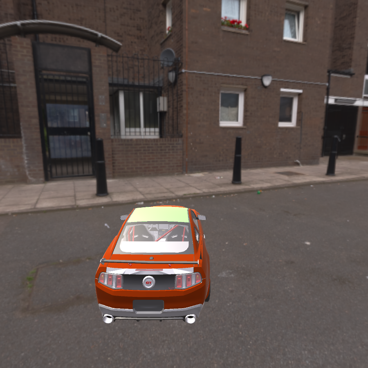

In [45]:
image,labels,center_map,img_dor=train_data[0]
transforms.ToPILImage()(image).resize((368,368))

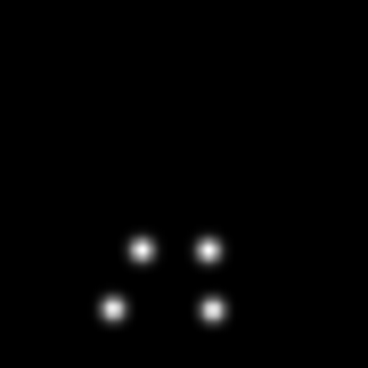

In [46]:
cum_labels=torch.sum(labels,axis=0)
transforms.ToPILImage()(cum_labels).resize((368,368))

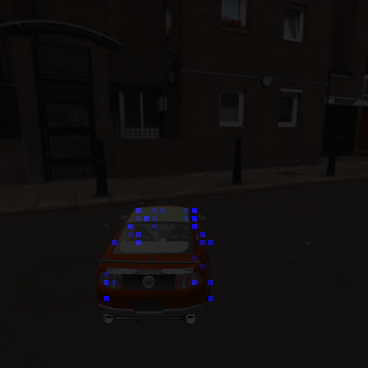

In [ ]:
label_locations=get_locations(labels)
label_background=img.copy()
label_output=generate_output_image(output.clone(),label_locations)
background.paste(label_output,(0,0),label_output)
background

In [49]:
#Prediction
i=0
for image,labels,center_map,img_str in train_data:
  pred_6=net(torch.unsqueeze(image,dim=0),torch.unsqueeze(center_map,dim=0))[0][-1] #Final stage output
  output=pred_6.clone().detach()*0
  pil_image=transforms.ToPILImage()(image)
  background=pil_image

  output_image=generate_output_image(output,get_locations(pred_6))
  background.paste(output_image,(0,0),output_image)
  background.save(annotation_save_dir+'Image'+str(i)+'.PNG')
  i+=1
  #import ipdb
  #ipdb.set_trace()
  print("Saving Image ",i)

> <ipython-input-49-ecc13285dc65>(15)<module>()
     13   import ipdb
     14   ipdb.set_trace()
---> 15   print("Saving Image ",i)

ipdb> background
<PIL.Image.Image image mode=RGB size=368x368 at 0x7FA954752630>
ipdb> background.show()
ipdb> torch.max(pred_6)
tensor(0.0778, device='cuda:0', grad_fn=<MaxBackward1>)
ipdb> c
Saving Image  1
> <ipython-input-49-ecc13285dc65>(14)<module>()
     13   import ipdb
---> 14   ipdb.set_trace()
     15   print("Saving Image ",i)

ipdb> c
Saving Image  2
> <ipython-input-49-ecc13285dc65>(15)<module>()
     13   import ipdb
     14   ipdb.set_trace()
---> 15   print("Saving Image ",i)

ipdb> torch.max(pred_6)
tensor(0.0895, device='cuda:0', grad_fn=<MaxBackward1>)
ipdb> c
Saving Image  3
> <ipython-input-49-ecc13285dc65>(14)<module>()
     13   import ipdb
---> 14   ipdb.set_trace()
     15   print("Saving Image ",i)

ipdb> c
Saving Image  4
> <ipython-input-49-ecc13285dc65>(15)<module>()
     13   import ipdb
     14   ipdb.set_trace()
---> 15   

BdbQuit: ignored

In [48]:
!pip install ipdb

  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10973 sha256=c6f7347e6730564779673b52780ce51b45775bf4e02842919c9d1f25ed269a95
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


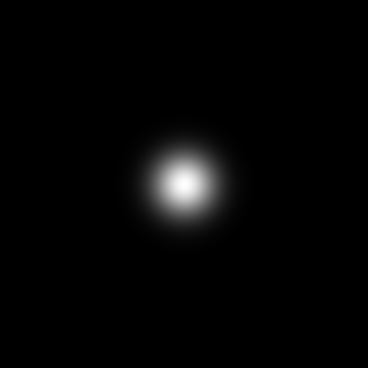